In [1]:
!pip install pandas

In [1]:
import pandas as pd

# Load dataset
file_path = 'dataset/mental_health.csv'
data = pd.read_csv(file_path)

# Display
data.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [18]:
from textblob import TextBlob

#classify sentiment
def classify_sentiment(text):
    # Hitung sentiment polarity
    polarity = TextBlob(text).sentiment.polarity

    if polarity > 0.5:
        return 0  # sangat normal
    elif 0 <= polarity <= 0.5:
        return 1  # normal
    elif -0.5 < polarity < 0:
        return 2  # kurang normal
    else:
        return 3  # buruk

data['new_label'] = data['text'].apply(classify_sentiment)



In [19]:
data['new_label'].value_counts()

new_label
1    16102
2    10211
3      967
0      697
Name: count, dtype: int64

<ipython-input-20-9143dfcbc1a9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='new_label', data=data, palette='RdBu')


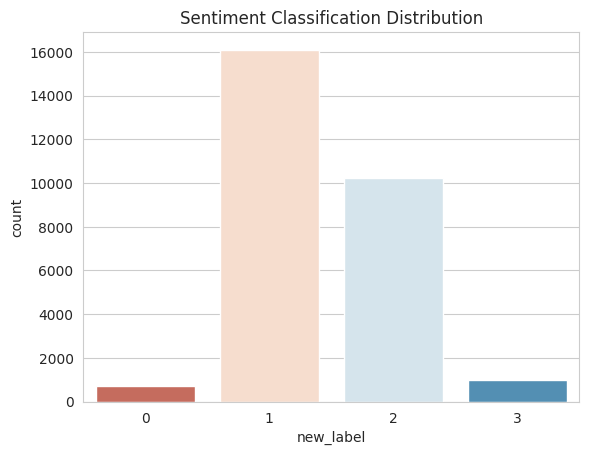

In [20]:
#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

sns.countplot(x='new_label', data=data, palette='RdBu')
plt.title('Sentiment Classification Distribution')
plt.show()

In [23]:
#renew label
data = data.drop(columns=['true_label'])
data = data.rename(columns={'new_label': 'label'})

data.head()

,text,label
0,dear american teens question dutch person hear...,1
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,1
3,im done trying feel betterthe reason im still ...,2
4,worried year old girl subject domestic physic...,2


In [24]:
data.to_csv('dataset/mental_health_sentiment.csv', index=False)

# Building Model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

file_path = 'dataset/mental_health_sentiment.csv'
df = pd.read_csv(file_path)

df.dropna(inplace=True)

In [26]:
# Split data
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#TF-IDF features
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logitic Regression

In [30]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = model.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


# Lightgbm

In [38]:
import lightgbm as lgb
#LightGBM
train_data = lgb.Dataset(X_train_tfidf, label=y_train)
test_data = lgb.Dataset(X_test_tfidf, label=y_test, reference=train_data)

In [39]:
# Define parameters
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [43]:
# Train the model
model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[train_data, test_data])

# Predict on test data
y_pred = model.predict(X_test_tfidf)
y_pred_labels = [list(x).index(max(x)) for x in y_pred]  # Convert probabilities to class labels


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.331255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260945
[LightGBM] [Info] Number of data points in the train set: 22381, number of used features: 4926
[LightGBM] [Info] Start training from score -3.668578
[LightGBM] [Info] Start training from score -0.548817
[LightGBM] [Info] Start training from score -1.016966
[LightGBM] [Info] Start training from score -3.347739


In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
accuracy

0.8679413867047892